# Time Series Forecasting with ARIMA

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

%matplotlib inline

### Data

In [2]:
data = pd.read_csv('carcount.csv', index_col=0)
data.index = pd.to_datetime(data.index)
data.head()

,day.of.week,car.count,weather,cloud.indicator
date,,,,
2010-01-01,Friday,101,0.1,clear
2010-01-02,Saturday,34,0.2,cloudy
2010-01-03,Sunday,113,0.4,clear
2010-01-04,Monday,5,0.6,cloudy
2010-01-05,Tuesday,124,0.1,clear


In [3]:
# examine shape of dataframe, variable types
print(data.shape)
print(data.dtypes)

(2373, 4)
day.of.week         object
car.count            int64
weather            float64
cloud.indicator     object
dtype: object


In [4]:
# any missing values?
data.isnull().values.any()

False

### Exploratory Data Analysis

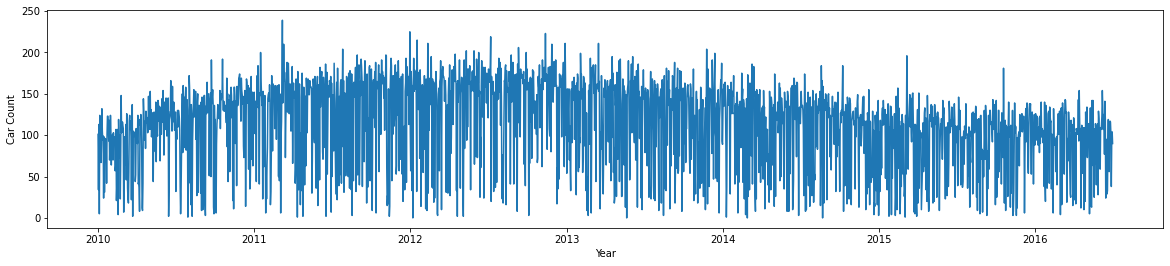

In [5]:
# plot car count over all years
plt.figure(figsize=(20,4))
ax = plt.gca()
ax.set_xlabel('Year')
ax.set_ylabel('Car Count')
plt.plot(data.index, data['car.count'])
plt.show()

Prime riflessioni sui dati: c'è una forte tendenza in tutti i dati, con fluttuazioni estreme. Sarà necessario esaminare più da vicino i dati utilizzando un periodo di tempo più breve per capire perché il conteggio delle auto potrebbe arrivare fino a 0-5 in alcuni giorni. Non vedo alcuna tendenza stagionale annuale.

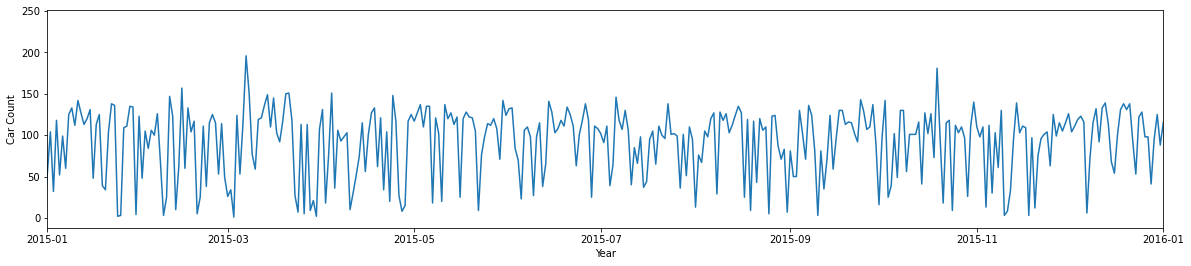

In [6]:
# car count for 2015
start = datetime.datetime(2015,1,1)
end = datetime.datetime(2016,1,1)

plt.figure(figsize=(20,4))
ax = plt.gca()
ax.set_xlim(start, end)
ax.set_xlabel('Year')
ax.set_ylabel('Car Count')
plt.plot(data['car.count']);

Altri pensieri iniziali: perché c'è così tanta variazione? Quali sono i cali improvvisi di dati? Sono collegati al tempo e a quanto freddo/quanto piove? Probabilmente no, la gente ha bisogno di fare shopping. È collegato a quanto possono essere torbide le riprese aeree e all'affidabilità dei nostri dati?

### Cloud Indicator Variable

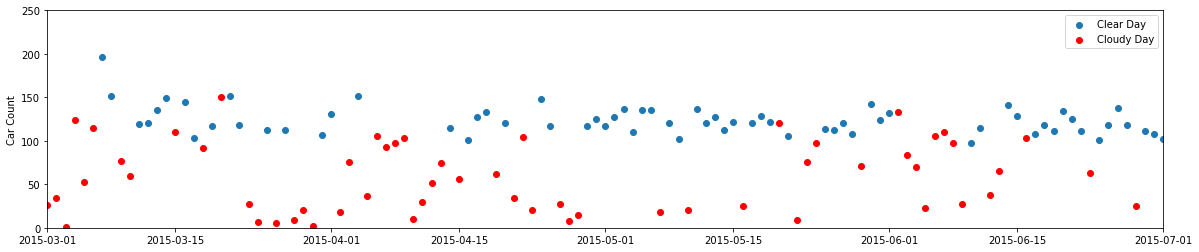

In [7]:
# let's take a closer look: summer 2015
start = datetime.datetime(2015,3,1)
end = datetime.datetime(2015,7,1)

cloudy_data = data.loc[(data['cloud.indicator'] == 'cloudy')]
clear_data = data.loc[(data['cloud.indicator'] == 'clear')]

plt.figure(figsize=(20,4))
ax = plt.gca()
ax.set_xlim(start, end)
ax.set_ylim(0, 250)
ax.set_ylabel('Car Count')
plt.scatter(clear_data.index, clear_data['car.count'])  
plt.scatter(cloudy_data.index, cloudy_data['car.count'], color='r');     
ax.legend(['Clear Day', 'Cloudy Day'])


Utilizzando un scatterplot, possiamo vedere il conteggio giornaliero delle singole auto. Tutti i giorni con un numero di auto molto basso sono dei giorni nuvolosi, quando il conteggio delle macchine potrebbe essere non valido. Potremmo considerare tutti i dati dei giorni nuvolosi come corrotti o per contenere un certo grado di inaffidabilità. 

### Outliers

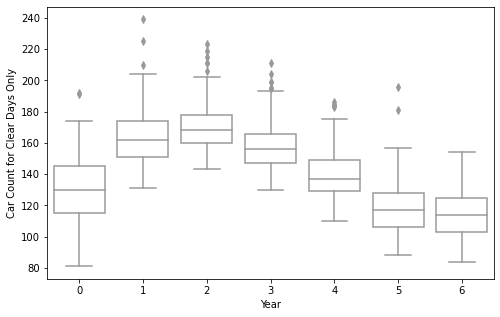

In [8]:
# plot outliers by year
data_boxplot = []
for year in range(2010, 2017):
    data_boxplot.append(clear_data.loc[(clear_data.index.year == year)]['car.count'])
    
import seaborn as sns
plt.figure(figsize=(8,5))
ax = plt.gca()
sns.boxplot(data=data_boxplot, color='w', whis=1.5)
ax.set_xlabel('Year')
ax.set_ylabel('Car Count for Clear Days Only');

Outlier analysis: se conserviamo tutti i dati (anche quelli dei giorni nuvolosi), questo produrrà un IQR fuorviante, molto più grande di quello reale. Potremmo togliere tutti i dati dei giorni nuvolosi.

In [9]:
# TODO remove outlier data from dataset

### Weather Variable

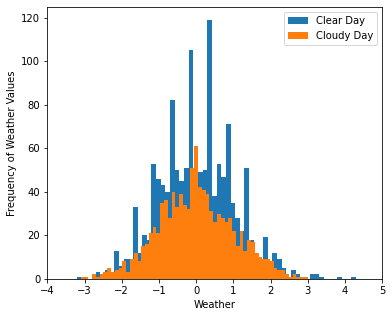

In [10]:
# frequency of Weather Indicator
plt.figure(figsize=(6,5))
ax = plt.gca()
ax.set_xlim(-4, 5)
plt.hist(clear_data['weather'], bins=60)
plt.hist(cloudy_data['weather'], bins=60)
ax.set_ylabel('Frequency of Weather Values')
ax.set_xlabel('Weather')
ax.legend(['Clear Day', 'Cloudy Day']);

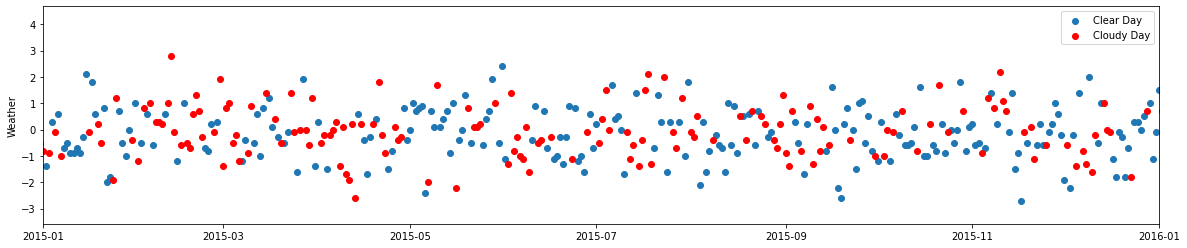

In [11]:
# seasonal trends for weather
start = datetime.datetime(2015,1,1)
end = datetime.datetime(2016,1,1)

plt.figure(figsize=(20,4))
ax = plt.gca()
ax.set_xlim(start, end)
ax.set_ylabel('Weather')
plt.scatter(clear_data.index, clear_data['weather'])  
plt.scatter(cloudy_data.index, cloudy_data['weather'], color='r')     
ax.legend(['Clear Day', 'Cloudy Day']);


Non esiste una correlazione evidente tra il tempo e la la variabile Weather.

### Day of Week

Text(0, 0.5, 'Total Car Count')

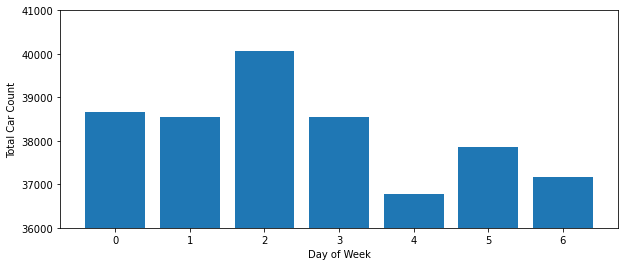

In [12]:
# TODO label properly x-axis
day = data['day.of.week'].unique()
plt.figure(figsize=(10,4))
ax = plt.gca()
plt.bar(np.arange(0,len(day)), data.groupby('day.of.week').sum()['car.count'])
ax.set_ylim(36000, 41000)
ax.set_xlabel('Day of Week')
ax.set_ylabel('Total Car Count')

Il giorno della settimana potrebbe essere una caratteristica importante da considerare

## Forecasting

La variabile meteo e l'indicatore di nuvole sono variabili non troppo utili, quindi possono essere eliminate. L'unica altra informazione è la componente temporale, che sarà utilizzata nel modello ARIMA. 

Per utilizzare ARIMA, prima bisogna accertarsi che i dati siano stazionari (tempo, varianza, co-varianza non dovrebbero dipendere dal tempo). Utilizzeremo il Dickey-Fuller Test

### Stationarity

In [13]:
def test_stationarity(ts):
    stats = ['Test Statistic','p-value','Lags','Observations']
    df_test = adfuller(ts, autolag='AIC')
    df_results = pd.Series(df_test[0:4], index=stats)
    for key,value in df_test[4].items():
        df_results['Critical Value (%s)'%key] = value
    print(df_results)

In [14]:
test_stationarity(clear_data['car.count'])

Test Statistic         -1.607026e+01
p-value                 5.516782e-29
Lags                    0.000000e+00
Observations            1.352000e+03
Critical Value (1%)    -3.435196e+00
Critical Value (5%)    -2.863680e+00
Critical Value (10%)   -2.567909e+00
dtype: float64


c:\python\lib\site-packages\numpy\linalg\linalg.py:1872: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)


I dati del conteggio delle auto non sono stazionari (il p-value è maggiore del valore critico). Ha bisogno di alcune trasformazioni. 

In [15]:
# first difference
clear_data['diff'] = clear_data['car.count'] - clear_data['car.count'].shift(1)  
test_stationarity(clear_data['diff'].dropna(inplace=False))

#TODO: address warning 

Test Statistic         -1.090358e+01
p-value                 1.142956e-19
Lags                    2.400000e+01
Observations            1.327000e+03
Critical Value (1%)    -3.435287e+00
Critical Value (5%)    -2.863720e+00
Critical Value (10%)   -2.567931e+00
dtype: float64


<ipython-input-15-2381c5ce841c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clear_data['diff'] = clear_data['car.count'] - clear_data['car.count'].shift(1)


L'ordine d pari a 1 ha reso i dati stazionari

### ACF and PACF Graphs

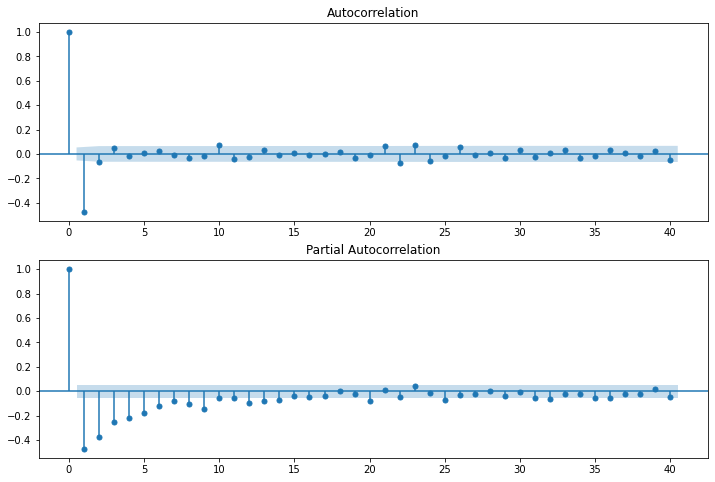

In [16]:
# ACF, PACF graphs to help determine order of ARIMA model, again statsmodel has these handy functions built-in
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(clear_data['diff'][1:], lags=40, ax=ax1)   # first value of diff is NaN
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(clear_data['diff'][1:], lags=40, ax=ax2)

Sembra che l'ACF sia in ritardo di 1

### Fitting Model

c:\python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                              ARMA Model Results                              
Dep. Variable:              car.count   No. Observations:                 1353
Model:                     ARMA(1, 0)   Log Likelihood               -5911.542
Method:                       css-mle   S.D. of innovations             19.107
Date:                Wed, 28 Oct 2020   AIC                          11829.084
Time:                        18:23:47   BIC                          11844.714
Sample:                             0   HQIC                         11834.936
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             143.6821      1.620     88.696      0.000     140.507     146.857
ar.L1.car.count     0.6798      0.020     34.036      0.000       0.641       0.719
                                

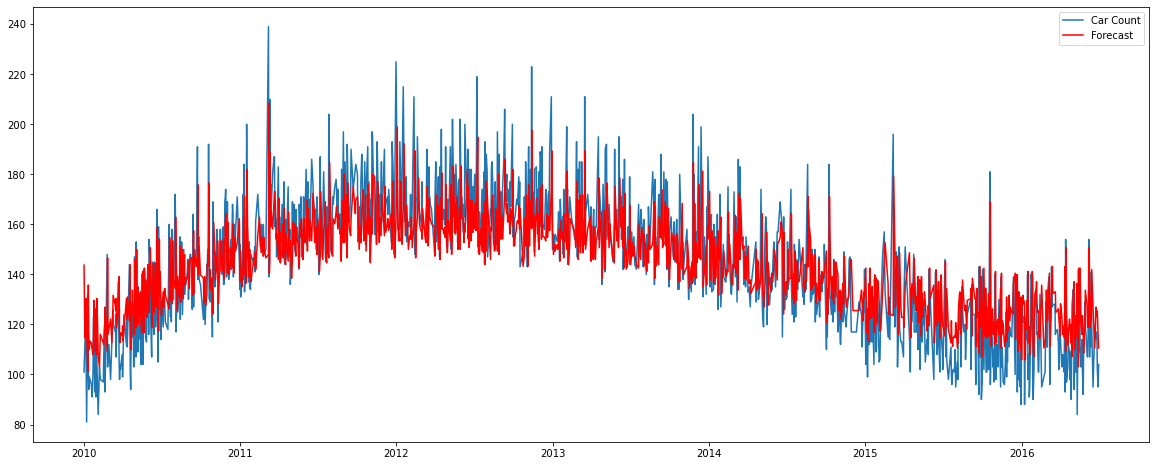

In [17]:
# fit ARIMA model
fig = plt.figure(figsize=(20,8))
model = ARIMA(clear_data['car.count'], order=(1,0,0)) 
ax = plt.gca()
results = model.fit() 
plt.plot(clear_data['car.count'])
plt.plot(results.fittedvalues, color='red')
ax.legend(['Car Count', 'Forecast'])

print(results.summary())

c:\python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:              car.count   No. Observations:                 1353
Model:                     ARMA(1, 1)   Log Likelihood               -5602.656
Method:                       css-mle   S.D. of innovations             15.193
Date:                Wed, 28 Oct 2020   AIC                          11213.312
Time:                        18:23:47   BIC                          11234.152
Sample:                             0   HQIC                         11221.115
                                                                              
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             122.0478     20.644      5.912      0.000      81.587     162.509
ar.L1.car.count     0.9992      0.001   1309.165      0.000       0.998       1.001
ma.L1.car.count    -0.9361      0.009   -105.683      0.000      -0.953      -0.919
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0008           +0.0000j            1.0008            0.0000
MA.1            1.0683           +0.0000j            1.0683            0.0000
-----------------------------------------------------------------------------
"""

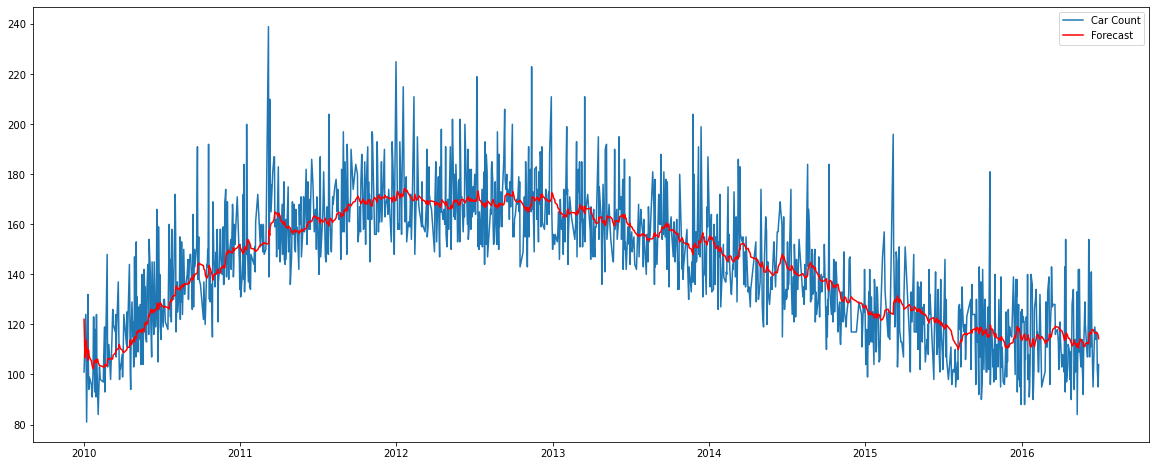

In [18]:
# fit ARIMA model
fig = plt.figure(figsize=(20,8))
model = ARIMA(clear_data['car.count'], order=(1,0,1)) 
ax = plt.gca()
results = model.fit() 
plt.plot(clear_data['car.count'])
plt.plot(results.fittedvalues, color='red')
ax.legend(['Car Count', 'Forecast'])

results.summary()

### Forecasting Model

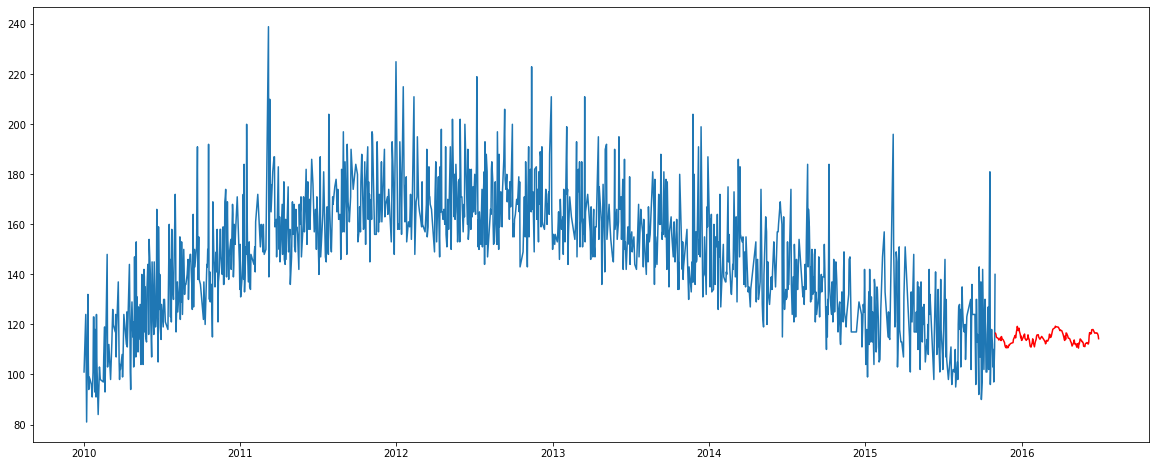

In [19]:
# forecast quick and dirty
# TODO: clean this up
fig = plt.figure(figsize=(20,8))
num_points = len(clear_data['car.count'])
x = results.predict(start=(1200), end=(1352), dynamic=False)

plt.plot(clear_data['car.count'][:1200])
plt.plot(x, color='r')

## Summary
L'ARIMA(1,0,0) tende a catturare la media della tendenza generale, che è inferiore a quella degli anni di maggior numero di auto e superiore a quella degli anni di minor numero di auto. L'ARIMA(1,0,1) va meglio con il trend generale, ma non lo fa così bene con la variabilità e il rumore.

Spunti aggiuntivi:
1. Le tendenze degli anni passati (2015-2016) sono più rilevanti rispetto a quelle dei primi anni (2010-2012). Si potrebbe cercare di adattare il modello ARIMA ai soli dati degli ultimi anni per le previsioni del prossimo anno o due. 
2. Si potrebbe analizzare più a fondo la caratteristica meteorologica nel caso in cui ci sia una qualche correlazione tra essa e il conteggio delle auto.
3. Sarebbe interessante vedere se i dati mancanti dei giorni nuvolosi possono essere riempiti in qualche modo.
4. E' possibile che con alcune caratteristiche come il tempo, il giorno della settimana e l'anno, un algoritmo più sofisticato potrebbe essere addestrato per prevedere meglio il conteggio delle auto.
5. Infine, sarebbe bene aggiungere più contesto di business. Ad esempio, c'è qualche indicazione che la tendenza al ribasso dal 2013 in poi continuerà? È stato costruito un altro Wal-mart a 10 miglia di distanza nel 2013 per competere con questo? Forse è stato costruito un centro commerciale nella parte nord della città e i prezzi delle case hanno iniziato a scendere quando i proprietari di case hanno iniziato a trasferirsi nella parte nord della città? 